# Amazon Forest Fires

**Heatsopt dataset**

Source [Forest Fires 1998-2017 (*Incêndios Florestais*)](https://dados.gov.br/dataset/sistema-nacional-de-informacoes-florestais-snif/resource/949310f1-05bc-4f56-a63f-aef67aac6164)

**Deforestation dataset**

Source [Deforestation Dashboard](http://terrabrasilis.dpi.inpe.br/app/dashboard/deforestation/biomes/legal_amazon/rates)

***

**QUESTIONS**

* What the heatspots dataset tells us? Why Amazon is relevant?
* How much weights the *deforestation* factor?
* What is hapenning in the amazon??


**GUIDELINES**

1. Import heatspot dataset
2. Initial Data Exploration (Major overall characteristics) -> Answer Why Amazon?
3. What is Amazon? Explore characterístics of heatspots in Amazon
4. Deforestation (How does it affect forest fires?)
5. Incorporate Wheather Analysis
6. Predictive model 

In [30]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from resources.io import read_states_geometry, read_heatspots_dataset, read_deforestation_dataset, load_data
from resources.plotting import *
from resources.utils import summary_dataset, get_peak_month, Bootstrap

## 1. Initial Exploratory Data Analysis

* This section is dedicated to the initia exploration of the heatspots data set. This exploration involves:

    * Visualization of the general distribution of the variable `Number` (number of heatpots detected on a month).

    * Visualization of the states with the most number of heatspots detected.

    * The Analysis of trend of the number of heatspots over time (the timespan covered by the data set)

In [31]:
# importing heatspots dataset 

data = read_heatspots_dataset()
print(summary_dataset(data))

# setup font props for plots
plt.rcParams['font.family'] = 'Arial' 
plt.rcParams['font.size'] = 11 

-----------------------------------  |  -----------------------------------
          Data Set Summary           |            Statistics          
-----------------------------------  |  -----------------------------------
Starts at                   1998-01  |           Year   Month   Number
Ends at                     2017-11  |  count  6453.0  6453.0   6453.0
Type                      period[M]  |  mean   2007.5     6.5    567.6
Entries                        6453  |  std       5.7     3.4   1648.5
Fields (5)      Year, State, Month,  |  min    1998.0     1.0      0.0
                   Number, St_codes  |  25%    2002.0     3.0      9.0
NULL                              0  |  50%    2007.0     6.0     55.0
Memory[KB]                    302.5  |  75%    2012.0     9.0    284.0
-----------------------------------  |  max    2017.0    12.0  25963.0
             Data Types              |  
-----------------------------------  |  
Year                          int64  |  
State          

### 1.1. Studying Heatspots Numbers Distribution (by State)

Plotting the distributions (CDF) of the data within the data set.

The heatspots are stratified by the state in accordance with the field `St_codes` where they occured. There are 3 plots:

* The left most graph shows the distribution correspondent to each state
* The middle graph is the same as the one on the left, but with the x-axis zoomed in
* The right most graph is similar to the first, but with the data log-transformed

Text(0.5, 0.98, 'EMPIRICAL DISTRIBUTION CDF (NUMBER) BY STATES')

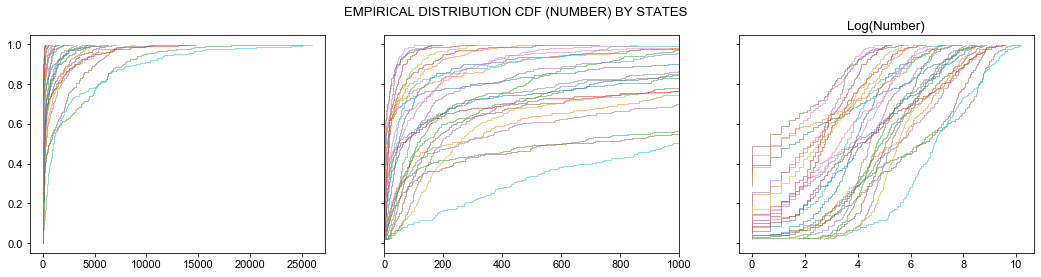

In [32]:
# Analysis of the Distribution by States

fig,axs = plt.subplots(1,3, figsize=(18,4), sharey=True)
states = data['St_codes'].unique()
for code in states:
    x = data[data['St_codes'] == code]
    lw = .5
    xs = np.arange(len(x))/len(x)
    axs[0].step(x['Number'].sort_values(), xs, lw=lw)
    axs[1].step(x['Number'].sort_values(), xs, lw=lw)
    axs[2].step(x['Number'].map(np.log).sort_values(), xs, lw=lw)
axs[1].set_xlim(0,1000)
axs[2].set_title("Log(Number)")
fig.suptitle('EMPIRICAL DISTRIBUTION CDF (NUMBER) BY STATES')

**COMENTARY**

The heatspots `Number` distribution ($\text{CDF}$) have a fairly regular shape across the many states in Brazil.
From the *zoomed in* it can be seen that *most* have the variable `Number` heavily concentrated on values close do $0$ but at some point between $200 \text{~} 400$ the cdf curve flattens for differently levels of probabilities depending on the state to which the curve refers to.

A few states have a more evenly distribuited curve which will become more *S-like* after log-transformed. The phenomena relating to the varialbe `Number` may be different on those, that doesn't seem to be the majority.

It seems reasonable the most of the states follows the same basic pattern and can be directly compared with regards to the variable `Number`.

In [33]:
# Importing Brazilian states json files as GeoDataFrames

def map_plot_setup(**kwargs):
    """This function setup a pair fo axes for graph and map vizualization."""

    fig = plt.figure(**kwargs)

    axs = []
    ax = fig.add_axes([0, 0.25, .5, .65]); axs.append(ax) # bar plot
    ax = fig.add_axes([.6, .1, .4, .9]); axs.append(ax) # map plot
    

    axs[1].set_facecolor('lightgray')
    for spine in axs[1].spines.values():
        spine.set_visible(False)

    for axis in axs[1]._get_axis_list():
        axis.set_visible(False)
    
    return fig, axs

def split_description(df):
    def split_string(string):
        state, region = [s.strip() for s in string.split('/')]
        return pd.Series((state, region), index=['State', 'Region'])
    state_region = df['Description'].apply(split_string)
    return df.join(state_region)


# Composing Brazil geographic map

states_geometry = map(lambda df: df.dissolve(by='Name'), read_states_geometry('./data/geojson/*.geojson'))
brazil_map = pd.concat(states_geometry, axis=0) \
                .pipe(split_description)

brazil_map.index.rename('St_codes', inplace=True)

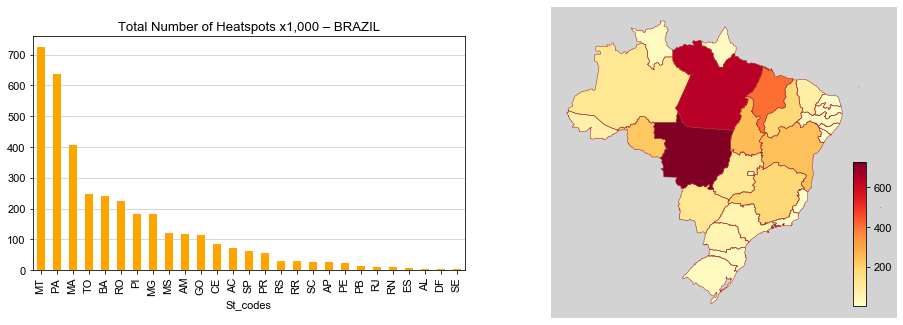

In [34]:
# Plotting setup

fig, axs = map_plot_setup(figsize=(12,5), constrained_layout=True)
cax = fig.add_axes([.95, .15, .015, .4])

# Brazil with heatspots number sum by State
brazil_map.boundary.plot(lw=.5, color='brown', ax=axs[1])
brazil_map.join(data.groupby('St_codes')['Number'].sum()).plot(column='Number', cmap='YlOrRd',
                    legend=True, ax=axs[1],cax=cax)

# Heatspots sum ordered on bar chart
data.groupby('St_codes').sum()['Number'].sort_values(ascending=False) \
                    .plot.bar(color='orange', ax=axs[0], zorder=2)
                    
axs[0].set_title('Total Number of Heatspots x1,000 – BRAZIL')
axs[0].grid(lw=.5, axis='y')

# Axis scale adjustment
axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos:int(x/1000)))
fig.get_axes()[-1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: int(x/1000)))

**COMENTARY**

* It can be seen that the occurence (those detected) of heatspots on the period convered by the data has been concentrated in few around the central/north regions in Brazil. It translate to that heatspots *aren't evenly or randomly* spread across the territory, but rather some regions are more likely from others regarding the occurrence of months with a account of heatspots detection.

* Adding to the previous observations, **under the spacial resolution** (states) present in the data set, the number of heatspots doesn't decrease smoothly from the area where it is concentraded, so a state wuth a high concentration of heatspots can be neighbor of another state with this quantity reduced manyu folds. *Possibly* the detections are hapenning in very localized area(s0 that are significantly smaller than the state where it is located.

### 1.2. Analisys of the Annual Number of Heatspots

The data is currently on a monnthy basis. The time series corresponding to the variable `Number` (number of heatspots) pertaining to each state will be plotted and further ahead the annual aggregate (sum) of `Number` is plotted.

* The objective is to observe what kind of behavior is present in the number of heatspots and how it related to the previous observations.

* For the last graph, the one which aggregates the quantities relative to states into one single number, a *exponential weighted moving average* is applied to the time series in order to reinforce any major trend that could be present in the data.

Text(0.5, 1.0, 'Heatspots number – By State')

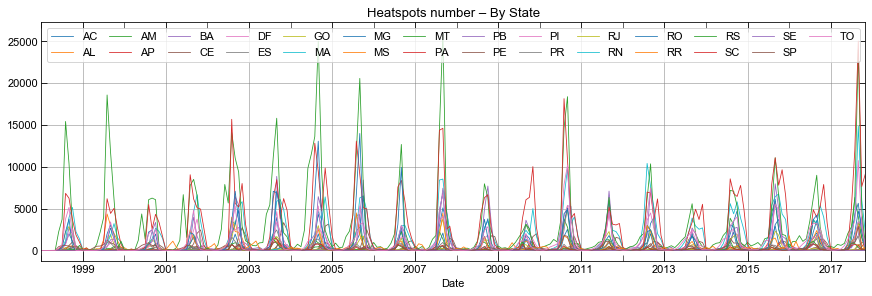

In [35]:
fig, ax = plt.subplots(figsize=(12,4), constrained_layout=True)
data.pivot_table(index='Date', columns='St_codes', values='Number').pipe(streamplot, legend=True, ax=ax)
ax.legend(mode='expand', ncol=14)
ax.set_title('Heatspots number – By State')

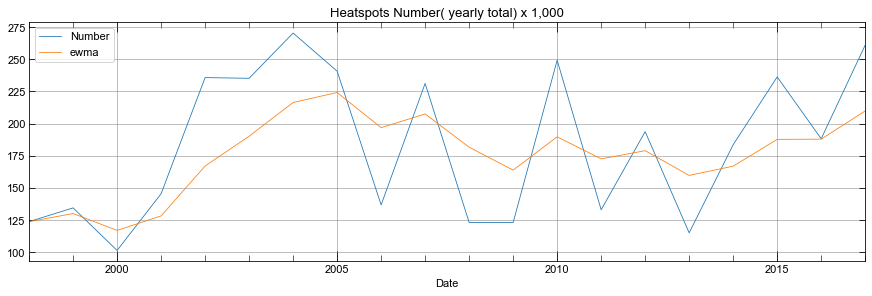

In [36]:
# plotting the yearly evolution with expotential weighted moving average (ewma)

fig, ax = plt.subplots(figsize=(12,4), constrained_layout=True)

data.groupby(data.index.asfreq('A'))[['Number']].sum() \
        .assign(ewma = lambda df: df.ewm(alpha=.3).mean()) \
        .pipe(streamplot, ax=ax, title='Heatspots Number( yearly total) x 1,000')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,pos: int(x/1000)))

**COMENTARY**

* From the first graph the data show very distinct cyclic characteristics with periodic peaks and valleys mostly *synced* (in pahse) ammong all states in the period available on the data.

* *As exptected*, the states that already showed to hold the highest concentration of heatspots earlier (MT, PA, ...) are those with the highest peaks, and those seem of be the most relevant factors for the appearence of peaks in the yearly aggregated heatspots summation for the **earlier** period of the graph.

* The peaks on the first graph are mirroed on the second but **not** on the same way over the entire period. As of 2004 and 2005 the total number of heatpots peaks with a great contribution from state MT, and the same repeats in 2007. But since 2010~2011 years like 2015 hold a significant high peak with no correspondent major state contribuint which imply that other states may be undergoing an increase on their number of heatspots independently.

* The *EWMA* (exponential weighted moving average) captures a rise from start date up until 2004 from when a descending trend starts, but on the ending years the EWMA captures another rise what according to the other observations can have a greater contribution from states that weren't contributing in the beginning of the period in analysis.

These issues wll be investigated in more depth ahead.

***

### 1.3. Detailed Analysis of the Evolution in Heatspots Number

This section follows from where the previous one left off.
The main purpose is to exam how the number of heatspots from each state relates to the observed rising in the total heatspots number that some states experienced mainly on the ending years of the period covered by the data.

For this reason an *index* was designed to address which states are undergoing the most *rate of change* regarding the heatspots number in such way that positive values indicates an overall increase and negative values the opposite.

At the end, the index will be computed in a way to best represent each state according to the avaiable data and shown on a map that also includes the area that is officially considered as *amazon biome*.

**The index**

The index in question will be reffered to as *change of average heatspot rate* and will by computed for each time series corresponding to each state in the period covered by the data with respect to the **yearly total number of heatspots**\*.

Its computation follows the steps:

   1. A year is chosen to split a single time series into two, *before* and *after* respectively to the chosen split value.
   2. Sum the heatspots number found on both series.
   3. Normalize each value by dividing it by the *extent* of the period to which it belongs (average rate of change on each period).
   4. Subtract the normalized values and take the percentual change with respect to the period *before*.

The formula is shown below:

$$\frac{\frac{\sum_{T2} Number}{\Delta T_{2}} - \frac{\sum_{T1} Number}{\Delta T_{1}}}{\frac{\sum_{T1} Number}{\Delta T_{1}}}$$

with $T_1$ refering to the period *before* the splitting value and $T_2$ to the period *after*. $\text{Number}$ represents the number of heatspots aggregated (yearly total).

*\* The time period considered in the yearly aggregated data set doesn't include 2017 as not all months on this year are provided in the data which could bias/understimate values for the proposed procedure.*

**Computing the index "average rate of change overall"**

This index is arbitrary as it depends on the choice of the *splitting value* which is a `Year` on the time series.
In order to best represent the data and the changes each state undergoes this index is analysed for several different years as splitting values and its distribution on each state is represented on a boxplot.

In [37]:
def avgRateChange(df, split_value, on, by='St_codes'):
    """Function to computhe the Heatspots **average yearly rate**."""
    
    before = df.query("%s < @split_value"%on).groupby(by)['Number'].sum()
    after = df.query("%s >= @split_value"%on).groupby(by)['Number'].sum()

    values = df[on].unique()
    n_before = np.sum(values < split_value)
    n_after = len(values)  - n_before
    
    return (after * n_before/n_after - before) / before

heatspots_avgChange = [data.pipe(avgRateChange, on='Year', split_value=split_year) \
                            .rename(split_year)
                        for split_year in range(2006,2014)]

heatspots_avgChange = pd.concat(heatspots_avgChange, axis=1)

# computing overall index (mean)
heatspots_overall = heatspots_avgChange.mean(axis=1).rename('Index')

# sorting
heatspots_avgChange.sort_index(key=lambda x: heatspots_overall.loc[x], inplace=True, ascending=False)

Text(0.5, 0, 'Splitting Year')

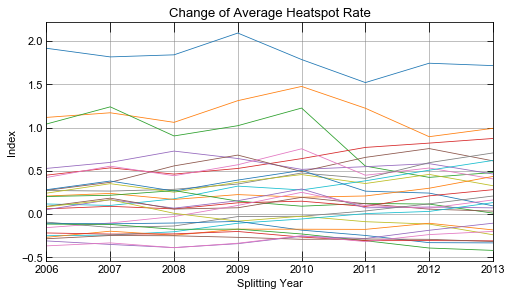

In [38]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
streamplot(heatspots_avgChange.T, legend=False, ax=ax, title='Change of Average Heatspot Rate')
ax.set_ylabel('Index')
ax.set_xlabel('Splitting Year')

Text(0.5, 1.0, 'Average Change Rate By State')

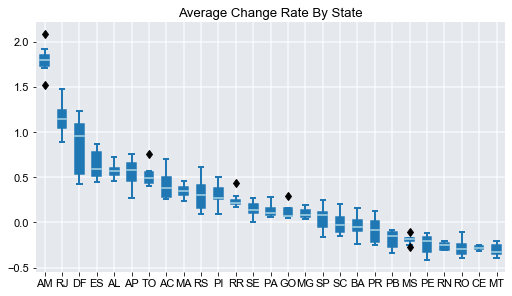

In [39]:
fig, ax = plt.subplots(figsize=(7,4), constrained_layout=True)
boxplot(heatspots_avgChange.apply(list, axis=1), patch_artist=True, ax=ax)
ax.set_xticklabels(heatspots_avgChange.index);
ax.set_title('Average Change Rate By State')

**COMENTARY**

The years for splitting value chosen lie in a time window from 2006 and 2013 which were years considered *safe* as being far enough from the limiting years on each side of the series, by so reducing any "border effect" the index could suffer.

* It can be seen that the values for the *index* on the majority of states remains *steady* or vary only slighly along the many years chosen for splitting the time series.

* Despite the fluctuations each states has on its index according to the year used as splitting value. those aren't detrimental to the accessment of the situation of those states that experience significant rate of change on heatspots numbers, whether for increasing or decreasing.
    * I'ts worth noting the state DF (which is in reality only a Federal District and called here as state only for convenience purposes) doesn't behave the same as the majority and its values could be confused with other states on similar situation.
    * The ordering of the states on the boxplot graph followed the mean value on the index distribution of each state, and this mean value will be used further ahead as *Overall Index value* with respect to eac state.

Text(0.5, 1, 'Heatspot Overall Index for States')

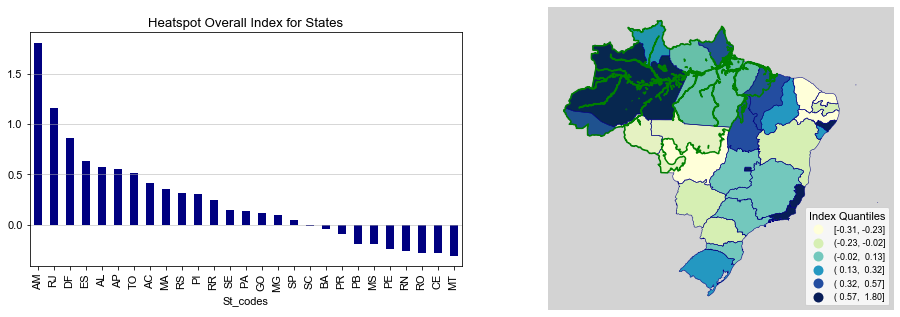

In [40]:
# Raeding Brazil's biomes 

biome = gpd.read_file('./data/biomas.json', crs=4236) \
            .set_index('cod_bioma')

# Plotting setup
fig, axs = map_plot_setup(figsize=(12,5), constrained_layout=False)

# axs = []
# ax = fig.add_axes([0, 0.25, .5, .65]); axs.append(ax) # bar plot
# ax = fig.add_axes([.6, .1, .4, .9]); axs.append(ax) # map plot

# axs[1].set_facecolor('lightgray')
# for spine in axs[1].spines.values():
#     spine.set_visible(False)

# for axis in axs[1]._get_axis_list():
#     axis.set_visible(False)


# Brazil with mapped heatspots Number increase index
brazil_map.boundary.plot(lw=.5, color='navy', ax=axs[1])
brazil_map.join(heatspots_overall).plot(column='Index', legend=True, cmap='YlGnBu', ax=axs[1],
                    scheme="quantiles", k=6, legend_kwds={'loc':4, 'title':'Index Quantiles', 'fontsize':9})

# Overlaying Amazon Biome
biome.loc[['AMZ']].plot(column='nom_bioma', ax=axs[1], color='green', alpha=.1)
biome.loc[['AMZ']].boundary.plot(ax=axs[1], color='green', lw=1.5)

# Heatspots number ordered on bar chart
heatspots_overall.sort_values(ascending=False) \
                    .plot.bar(color='navy', ax=axs[0])

axs[0].grid(lw=.5, axis='y')
axs[0].set_title('Heatspot Overall Index for States')

**COMENTARY**

The values represented by the bars are those referenced previously as **overall values** and are a proposed representation of the state of overall increase or decrease in heatspots numbers each states undergoes along the period covered by the data.

* **AM is the main problematic state**. Despite the following states – RJ, DF, ES and AL – being the next in line after **AM**, thair absolute heatspot numbers are very tiny and their index values could be misinterpreted as though they were suffering from a massive rise in their heatspots numbers. On this regard, The state **AM** (brazilian state of Amazônia) is **isolated** the region where the heatspots *are increasing*, with its index more than 3x the closesest state with *relevant* increase, TO at 0.5.

* A *green contour* is traced around the area corresponding to the **Amazon Biome**, where is found the Amazon Rainforest. It's notorious that this biome has being significantly affected when considering the number of heatspots as a representation of the fires taking place there. Not only the state PA has shown on of the highest heatspots counting, behind only MT, but it is also there where the heatspots numer is with the greatest increase rate as measure by the *overall index* presented above.

Below, for illustrative purposes, it's been taken the year of 2009 to split the data set and the distribution of both children data sets – the heatspots number prior to 2009 and after it. The distribution is shown as the logarithm of the cumulative density (CDF).

Text(0.5, 0, 'log(HEATSPOTS NUMBER)')

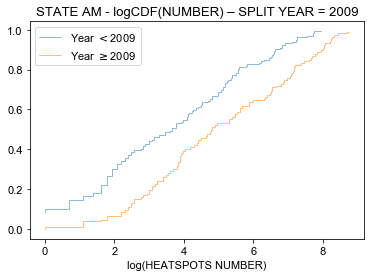

In [41]:
split_year = 2009
x1 = data.query('St_codes == "AM" & Year < @split_year')
x2 = data.query('St_codes == "AM" & Year >= @split_year')
plt.step(x1['Number'].map(np.log).sort_values(), np.arange(len(x1))/len(x1), lw=.5, label='Year $<$%d'%split_year)
plt.step(x2['Number'].map(np.log).sort_values(), np.arange(len(x2))/len(x2), lw=.5, label='Year $\geq$%d'%split_year)
plt.legend()
plt.title('STATE AM - logCDF(NUMBER) – SPLIT YEAR = %d'%split_year)
plt.xlabel('log(HEATSPOTS NUMBER)')

**COMENTARY**

The empirical distribution shows clearly what is hinted by the *heatspots change rate index* regarding the state AM. The rate on which the heatspots are detected on the later period are significantly greater than the previous period all across.

*Although 2009 is just one year among all possibilities, on the boxplot graph `Average Rate Change by State` it can be seen that for different years the index holds with only little dispersion, therefore the choice for 2009, although arbitrary, isn't detrimental to the conclusion.*

## SECTION SUMMARY

This section aimed an initial data exploration routine on the dataset related to the heatspots over Brazil. The goal is to understand the occurance of fires, investigate its causes and/or offer possible explanations focussing on their impact on the natural ecosystems.

Its was seen that, as heatspots detections are concerned, the number of heatspots are concentraded on few states on general, but on a more detailed perspective, the heatspots are found on a *dynamic situation* where its numbers are decreasing in some areas and increasing in others. It was *also* seen that the *increase* has been more **aggressive** on the state **AM**, right in the middle of the **amazon biome** where is found a great extension of the amazon rainforest.

The next sections are going to dive deeper into the properties and patterns embedded on the heatspots occurrence in the state AM and to explore its relations with the ongoing levels of *deforestation* and the actual climate on the region.

***

# 2. Deforestation

Deforestation is a currently issue in the amazon region, as well on othersm and is pointed out as one of the responsibles for fires on areas covered by vegetation. This section aims into explore how the deforestation may be related with the abnormal increase of heatspots in the amazon, specifically those observed in the state **AM**.

The deforestation data origins from the project *Terra Brasilis* which is a platform designed to allow accessment of geographic data derived from environmental monitoring and comprises *the annual increments of deforested areas* (on squared kilometers) in the Legal Amazon.

*The Legal Amazon is a social-geographic division in Brazil that envelops all states under the Amazon basins, which itself is mostly covered by the Amazon Rainforest. Thus the heatspots numbers for this analysis will be aggregated yearly and merged with the deforestation data set.*

In [42]:
# importing deforestation data set / Incremental Area Deforestaded (yearly)

def load_st_codes(path='./data/misc/st_codes.pkl'):
    return pickle.load(open(path, 'rb'))

deforest = read_deforestation_dataset() \
                .assign(St_codes = lambda df: df['State'].map(load_st_codes()))

print(summary_dataset(deforest))

# merging deforestation data into heatspots (yearly)
heatspots_yearly = data.groupby(['St_codes', 'Year'], as_index=False)['Number'].sum() \
        .merge(deforest, on=['St_codes', 'Year']) \
        .set_index('Year').sort_index() \
        .loc[:2016]

-----------------------------------  |  -----------------------------------
          Data Set Summary           |        Statistics      
-----------------------------------  |  -----------------------------------
Entries                         282  |           Year     Area
Fields (4)       Year, State, Area,  |  count   282.0    282.0
                           St_codes  |  mean   2003.6   1581.6
NULL                              0  |  std       9.3   2167.9
Memory[KB]                      8.9  |  min    1988.0      7.0
-----------------------------------  |  25%    1996.0    253.0
             Data Types              |  50%    2004.0    630.5
-----------------------------------  |  75%    2012.0   1744.0
Year                          int64  |  max    2019.0  11814.0
State                        object  |  
Area                        float64  |  
St_codes                     object  |  
---------------------------------------------------------------------------


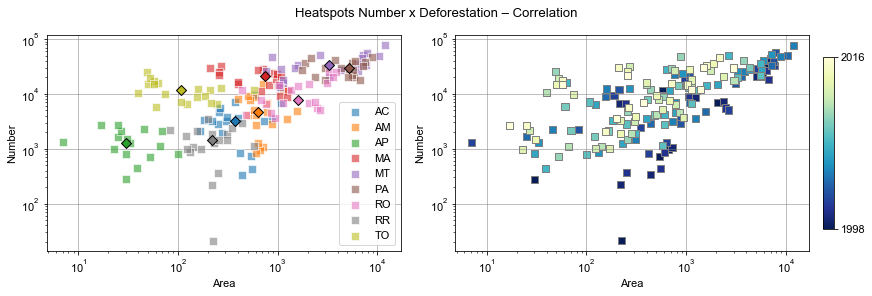

In [43]:
# plotting setup

fig, axs = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True)
cbar_props = {'shrink':.8, 'ticks':heatspots_yearly.index.unique()[[0, -1]], 'aspect':50}

# plotting Area x Number - Category: St_codes w/ Medians
fig.suptitle('Heatspots Number x Deforestation – Correlation')
heatspots_yearly.sort_values(by='St_codes').groupby('St_codes', as_index=False).median() \
                            .pipe(scatterplot, x='Area', y='Number', col='St_codes',
                            marker='D', edgecolor='k', s=50, ax=axs[0], zorder=5)

heatspots_yearly.sort_values(by='St_codes').pipe(scatterplot, ax=axs[0], x='Area', y='Number', col='St_codes',
                            marker='s', s=50, edgecolor='w', legend=True, alpha=.6, zorder=2)

# plotting Area x Number - color map: Year
heatspots_yearly.pipe(scatterplot, ax=axs[1], x='Area', y='Number', c='index', cmap='YlGnBu_r',
                            marker='s', colorbar=True, cbar_kwds=cbar_props, s=50, edgecolor='gray')

for ax in axs:
    ax.grid(lw=.5, color='gray')
    ax.loglog()

**COMENTARY**

Both graphs presents the paired data points of *heatpots number* and *deforeation area in km$^2$* on a log-log scale among the stated during the common period within the datasets.

The data points seems to habe a fair positive correlation as for the greater deforestation, the greater heatspots number. But as soon as we frame the data into its built-in structure that earlier deduction becomes questionable. On the *left* is shown the data points colored by which state it belongs to (with the median as a diamond-shaped symbol) and on the *right* the same data points are shown temporally structured.

* Instead of a direct positive correlation between heatspots number and deforestation, it's more reasonable to state that *states with greater deforestation rate tend to have also greater heatspots numbers*. This interpretation is justified by the fact the data points from each state are clustered, thus the variation in the heatspots number measured by the *overall index*, on a *micro scale* may be due to other factors while on a *macro scale* mainly that interpretation holds.

* The graph on the left just corroborates that previously stated. It can be seen that over time the number of heatspots seems to have increased in many states (which was already observed and analysed) without necesseraly a corresponded increase in the deforestation rate.

*2017 was taken off from this analysis since this year isn't complete in the data and thefore could compromise the interpretation of the graphs.*

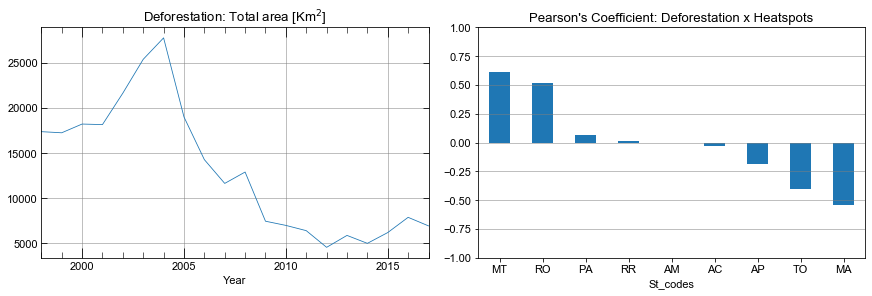

In [44]:
fig, axs = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)

deforest.groupby(pd.PeriodIndex(deforest['Year'], freq='A'))[['Area']].sum() \
    .loc['1998':'2017'].pipe(streamplot, legend=False, ax=axs[0], title='Deforestation: Total area [Km$^2$]')

heatspots_yearly[['Number', 'Area']].apply(np.log) \
            .groupby(heatspots_yearly['St_codes']).apply(lambda df: df.corr()['Number']['Area']) \
            .sort_values(ascending=False).plot.bar(rot=0, ax=axs[1],
            title='Pearson\'s Coefficient: Deforestation x Heatspots')
            
axs[1].set_ylim(-1,1)
axs[1].grid(axis='y', lw=.5, color='gray')

The graph on the left depicts the amount of deforestation occurred at each year among the states belonging to the *legal amazon* region and it reveals a overall reduction of the deforestation rate counting from 2004 onwards, which doesn't follow the overall increase in the heatspots on most areas of Brazil as told by the *heatstpos overall increate rate index* as well as by the scatter plot indicating the correlation between deforestation and heatspots number.

The computation of the *pearsons' coefficient* also tells that the heatspots variation can't be seen as a direct cause of the existent deforestation. The coefficient was computed over the same data presented on the above graphs (with the log-log scale incorporated).

On the state **AM** specifically, the coefficient is virtuallu null over the period on which both data sets (heatspots and deforestation) intersect, the increase in the heatspots number has no correlation with the deforestation (or any relation under a linear perspective).

## SECTION SUMMARY

Deforestation may happen for a few reasons, usually for openning clear areas for agriculture or illegal logging, where the former is directly involved with fires in the local vegetation.

The pattern of heatspots occurrences doesn't match strongly with the data regarding deforestation. The deforestation is positively correlated on states where heatspots number is decreasing, yet, with respect to the state **AM** the heatspots number **doesn't correlate significantly** with the deforestation. It may be the case where the heatspots on different areas are due to different phenomena or possibly many factors co-occurring.

***

# 3. Heatspots in Amazon

This section follow the sequence of analysis beong done so far and focus on identified critical problem regarding the heatspots which is its iccurrence on the state **AM** (amazon biome). It's been seen that this area is one suffering the **fastest increase** in heatspots number, its located on the core of the amazon biome. Also, it was found that *deforestation* alone isn't clearly related with the observed data.

The following analysis will explore how the wheather could be possible impacting or relating to the current case. The wheather data comes from climate stations spread over the area and a whole dedicated exploratory data analysis was perfomed independetly (which can be accessed on a separated notebook). The main highlightsfrom the conclusions obtained there and are of interest are:

* The wheather patterns are cyclic and conform into 2 main regimes: a hot-dry regime with higher temperatures, low precipitation levels and high insolation, alongside a wet-cloudy with regular rains

**ANALYSIS**

* #_heatspots total on seasons (implement a buffer zona between dry-hot and wet-not-so-hot seasons)
    - Observe where the heatspots are concentraded

* heatspots peak month x pca model peak month for coefficients
    - Chi sqaure test to avail the dependence of this variables

* Dry-hot month extension x pca model peak month for coefficients
    - yet to be thought

In [45]:
# filtering out only heatspots data referring to state AM
filter_AM = data['St_codes'].isin(['AM'])
data_AM = data[filter_AM][['Number']]

# joining with data from data from wheather explonatory data analysis
eda_wheather = load_data('wheather_data.pkl')
dry_season_stats = eda_wheather['dry_season_stats']
data_AM = data_AM.join(eda_wheather['data']['PCA'])
print(summary_dataset(data_AM))

# pivot table month x year for statistics and analysis
table_AM = data_AM[['Number']].assign(Year = lambda df: df.index.year,
                          Month = lambda df: df.index.month) \
                    .pivot_table(index='Month', columns='Year', values='Number')

# filling NaN (on 12-2017) with `median` of december (month 12)
table_AM = table_AM.T.fillna(value=table_AM.median(axis=1)).T

-----------------------------------  |  -----------------------------------
          Data Set Summary           |             Statistics          
-----------------------------------  |  -----------------------------------
Starts at                   1998-01  |         Number  coeff_1  coeff_2
Ends at                     2017-11  |  count   239.0    239.0    239.0
Type                      period[M]  |  mean    496.6      0.0      0.0
Entries                         239  |  std     988.0      2.3      1.0
Fields (3)         Number, coeff_1,  |  min       0.0     -4.4     -2.0
                            coeff_2  |  25%      11.0     -1.9     -0.7
NULL                              0  |  50%      64.0     -0.2     -0.1
Memory[KB]                     17.5  |  75%     490.0      1.8      0.6
-----------------------------------  |  max    6316.0      7.3      3.5
             Data Types              |  
-----------------------------------  |  
Number                        int64  |  
coeff

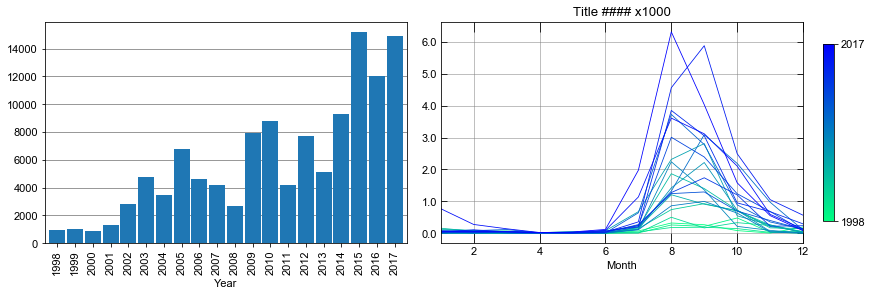

In [46]:
# Plotting AM Heatspots data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), constrained_layout=True)
norm = plt.Normalize(data['Year'].min(), data['Year'].max())
cbar_props.update(ticks=[norm.vmin, norm.vmax])

table_AM.sum(axis=0).plot.bar(width=.9, zorder=2, ax=ax1)
table_AM.pipe(streamplot, legend=False, cmap='winter_r', title='Title #### x1000', ax=ax2)
ax1.grid(lw=.8, color='gray', axis='y')
# ax.set_ylabel('Heatspots Number')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda i, pos: i/1000))
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='winter_r'), **cbar_props)

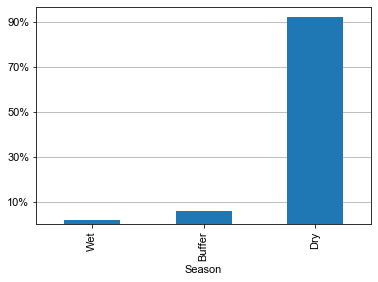

In [47]:
coeff_bins = [-float('inf'), -1, 1, float('inf')]
data_AM.assign(Season = np.digitize(data_AM['coeff_1'], coeff_bins)) \
    .replace({'Season':{1:'Wet', 2:'Buffer', 3:'Dry'}}) \
    .groupby('Season')['Number'].sum().div(np.sum(data_AM['Number'])) \
    .sort_values().plot.bar(zorder=2)

plt.grid(lw=.5, color='gray', axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda i, pos: '%.1d%%'%(i*100)))
plt.yticks(np.linspace(.1,.9,5));

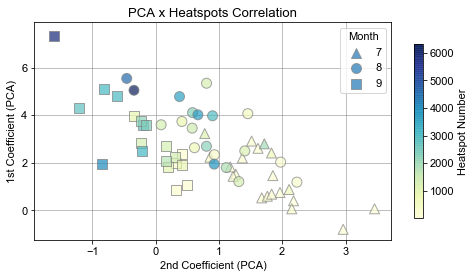

In [48]:
def plot_scatter(df):
        months = [7,8,9]
        df = df[df.index.month.isin(months)]

        plt.figure(figsize=(8,4))
        norm = plt.Normalize(df['Number'].min(), df['Number'].max())
        for mark, month in zip(['^', 'o', 's'], months):
                data = df[df.index.month.isin([month])]
                plot = plt.scatter(x=data['coeff_2'], y=data['coeff_1'], marker=mark, s=100,
                        c=data['Number'], alpha=.7, norm=norm, cmap='YlGnBu', label=month,
                        edgecolor='gray', zorder=2)
        plt.grid(lw=.5, color='gray')
        plt.legend(title='Month')
        plt.colorbar(shrink=.8, label='Heatspot Number')
        plt.xlabel('2nd Coefficient (PCA)')
        plt.ylabel('1st Coefficient (PCA)')
        plt.title('PCA x Heatspots Correlation')

data_AM[data_AM.index.month.isin([7, 8, 9])] \
        .assign(Month = lambda df: df.index.month) \
        .pipe(plot_scatter)

In [49]:
# Defining a class estimator for the pearsons' corr. coef.

class PearsonCoeff():
    """ This class estimates the Pearsons' correlation coefficient of a paired series
    represented as a column 2d ndarray."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.corr_coeff = np.corrcoef(X[:,0], X[:,1])
        return self

sig_level = 0.05
print('CORRELATION: PCA COEFFICIENTS X HEATSPOTS NUMBER')
print('CONFIDENCE LEVEL %d%%\n'%(100*(1-sig_level)))

# Computing the correlation heatspots x PCA coefficients (on months 7, 8, 9)

for coeff in ['coeff_1', 'coeff_2']:
    X = data_AM[data_AM.index.month.isin([7, 8, 9])][[coeff, 'Number']].values
    
    bootstrap = Bootstrap(estimator=PearsonCoeff,
                        attributes='corr_coeff',
                        transformation = lambda x: x[1,0],
                        n_samples=2000)
                        
    bootstrap.feed(X, alpha=sig_level)
    print('Pearsons\' Coefficient Estimation - %s\n'%coeff)
    print(bootstrap.summary(), '\n')

CORRELATION: PCA COEFFICIENTS X HEATSPOTS NUMBER
CONFIDENCE LEVEL 95%

Pearsons' Coefficient Estimation - coeff_1

   E[stat]           Std.Error                  [0.025 --- 0.975]
     0.708               0.079                    0.528     0.837 

Pearsons' Coefficient Estimation - coeff_2

   E[stat]           Std.Error                  [0.025 --- 0.975]
    -0.672               0.061                   -0.780    -0.540 



# 4. Machine Learning Model 
### ML Correto

1. Pegar o dataset wheater df
    * separar em 2 data sets. Train e Test
2. No train:
    * Criar normalizador
    * criar modelo PCA
    * Preparar Modelo ML

3. No Test
    *   Criar modelo utilizando os estimadores criados no `train`

4. Treinar Modelo
5. Testar / Analisar Resíduos

In [760]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [897]:
class AddSeasonCat(BaseEstimator, TransformerMixin):
    """Custom transformer for adding a categorial value **dry_season**."""

    def __init__(self, dry_season=True):
        self.dry_season = dry_season
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.dry_season:
            col = X[:,0] > 0
            return np.c_[X, col.astype(int)]
        else:
            return X

In [990]:
def train_test_split(df, ratio, target=None):
    """Splits data set into training set and testing set for forecasting.""" 
    def split_x(df):
        if target is None:
            return df
        else:
            return df.drop(target, axis=1), df[target]

    years = df.index.year.unique()
    split_year = years[int( ratio * len(years))]

    return split_x(df.loc[:str(split_year-1)]), split_x(df.loc[str(split_year):])

# getting raw data

data = load_data('./wheather_data.pkl')['data']['wheather'] \
            .join(data_AM[['Number']] \
            .apply(lambda s: np.log10(s + 1)), how='inner')

# splitting data set
train_set, test_set = train_test_split(data, .8, target='Number')
X_train, y_train = train_set
X_test, y_test = test_set

# setting transformation pipeline
n_components = 4
degree = 1
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('poly_transform', PolynomialFeatures(degree=degree, include_bias=False , interaction_only=False)),
    ('add_season', AddSeasonCat(dry_season=True))
], verbose=False)

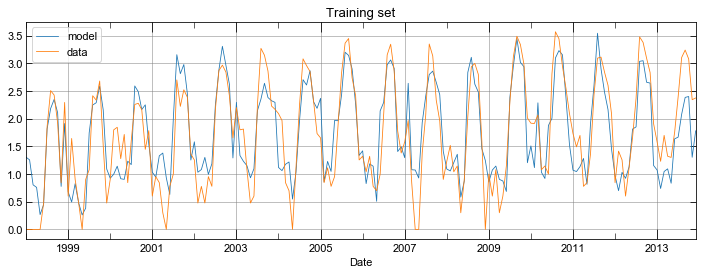

In [991]:
regr = LinearRegression().fit(pipe.fit_transform(X_train), y_train)

fig, ax = plt.subplots(figsize=(12,4))
pd.DataFrame({'model': regr.predict(pipe.fit_transform(X_train)), 'data': y_train.values}, index=train_set[0].index) \
        .pipe(streamplot, title='Training set', ax=ax)

MSE: 0.5094832642850087


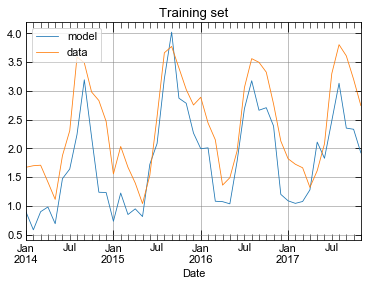

In [992]:

print('MSE:', mean_squared_error(y_test, regr.predict(pipe.fit(X_train).transform(X_test))))

fig, ax = plt.subplots(figsize=(6,4))
pd.DataFrame({'model': regr.predict(pipe.fit(X_train).transform(X_test)), 'data': y_test.values}, index=test_set[0].index) \
        .pipe(streamplot, title='Training set', ax=ax)

In [1015]:
# cross validation

X = pipe.fit_transform(X_train)
regressors = {'Tree-depth-3': DecisionTreeRegressor(max_depth=3).fit(X, y_train),
            'Tree-depth-4': DecisionTreeRegressor(max_depth=4).fit(X, y_train),
            'Tree-depth-5': DecisionTreeRegressor(max_depth=5).fit(X, y_train),
            'Linear': LinearRegression().fit(X, y_train)}

for label, regressor in regressors.items():
    scores = cross_val_score(regressor, X, y_train, scoring="neg_mean_squared_error", cv=5)
    print('Regressor: %s | Mean: %.3f | Std: %.3f'%(label, np.mean(scores), np.std(scores)))



Regressor: Tree-depth-3 | Mean: -0.354 | Std: 0.065
Regressor: Tree-depth-4 | Mean: -0.387 | Std: 0.074
Regressor: Tree-depth-5 | Mean: -0.439 | Std: 0.058
Regressor: Linear | Mean: -0.299 | Std: 0.064


In [1011]:

full_model = Pipeline([('preprocessing', pipe),
                        ('model', Ridge())])

param_grid = {'preprocessing__pca__n_components':[2, 3, 4, 5],
            'preprocessing__poly_transform__degree':[1, 2, 3],
            'preprocessing__poly_transform__include_bias':[False],
            'preprocessing__poly_transform__interaction_only':[True, False],
            'preprocessing__add_season__dry_season':[True, False],
            'model__alpha':np.logspace(-3, 2, 10)}

grid_search = GridSearchCV(full_model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

print('Best Parameters | score %f'%grid_search.best_score_)
for label, value in grid_search.best_params_.items():
    print('%s ... %s'%(label, str(value)))

final_model = grid_search.best_estimator_

Best Parameters | score -0.269626
model__alpha ... 0.5994842503189409
preprocessing__add_season__dry_season ... True
preprocessing__pca__n_components ... 5
preprocessing__poly_transform__degree ... 1
preprocessing__poly_transform__include_bias ... False
preprocessing__poly_transform__interaction_only ... True


MSE: 0.5344614157200621


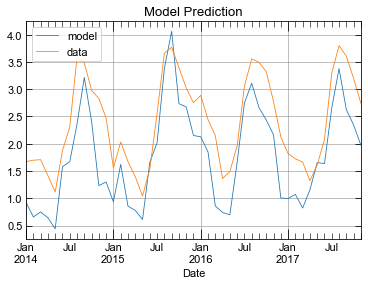

In [1016]:
# Testing Final Model

print('MSE:', mean_squared_error(y_test, final_model.predict(X_test)))

fig, ax = plt.subplots(figsize=(6,4))
pd.DataFrame({'model': final_model.predict(X_test), 'data': y_test.values}, index=test_set[0].index) \
        .pipe(streamplot, title='Model Prediction', ax=ax)

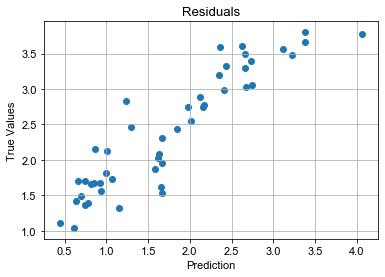

In [1018]:
plt.scatter(x=final_model.predict(X_test), y=y_test)
plt.xlabel('Prediction')
plt.ylabel('True Values')
plt.title('Residuals')
plt.grid()